In [58]:
pip install lightgbm

Defaulting to user installation because normal site-packages is not writeable
     ---------------------------------------- 1.5/1.5 MB 4.2 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [62]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from lightgbm import LGBMClassifier

import seaborn as sns



In [28]:
# Load features and labels with datetime index
X = pd.read_csv('../data/features_X.csv', index_col=0, parse_dates=True)


In [41]:
y = pd.read_csv('../data/labels_y.csv', index_col=0, parse_dates=True)
y = y.iloc[:, 0]  # grab the first (and only) column


In [29]:
X.head()

,SMA20,SMA50,RSI,MACD,MACD_Signal
Price,,,,,
Ticker,NaN,NaN,NaN,NaN,NaN
Date,NaN,NaN,NaN,NaN,NaN
2020-03-13,70.923007,74.025908,45.241583,-2.653158,-2.030566
2020-03-16,69.920359,73.747537,36.847040,-3.215642,-2.267581
2020-03-17,69.118871,73.534910,40.394245,-3.413785,-2.496822


In [30]:
X=X.dropna()
X.head()

,SMA20,SMA50,RSI,MACD,MACD_Signal
Price,,,,,
2020-03-13,70.923007,74.025908,45.241583,-2.653158,-2.030566
2020-03-16,69.920359,73.747537,36.847040,-3.215642,-2.267581
2020-03-17,69.118871,73.534910,40.394245,-3.413785,-2.496822
2020-03-18,68.186387,73.280818,39.022312,-3.649798,-2.727417
2020-03-19,67.271232,73.024383,38.591331,-3.829657,-2.947865


In [42]:
y.head()

Date
2020-03-13    0
2020-03-16    1
2020-03-17    0
2020-03-18    0
2020-03-19    0
Name: Target, dtype: int64

In [43]:

# Time-based split (no shuffle)
split_index = int(len(X) * 0.8)
X_train = X.iloc[:split_index]
X_test = X.iloc[split_index:]
y_train = y.iloc[:split_index]
y_test = y.iloc[split_index:]

print(f"Train size: {len(X_train)}")
print(f"Test size: {len(X_test)}")


Train size: 965
Test size: 242


In [44]:
# Initialize and train model
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

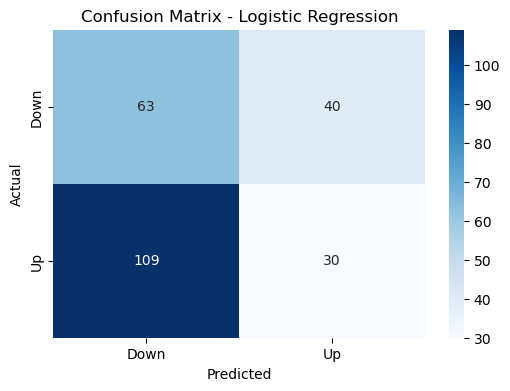

In [48]:

y_pred_lr = model.predict(X_test)

# Confusion matrix
conf_mat = confusion_matrix(y_test, y_pred_lr)

# Plot
plt.figure(figsize=(6, 4))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=['Down', 'Up'], yticklabels=['Down', 'Up'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Logistic Regression')
plt.show()

In [54]:

# Initialize and train
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predict
y_pred_rf = rf_model.predict(X_test)

# Evaluation
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Classification Report:\n", classification_report(y_test, y_pred_rf))


Random Forest Accuracy: 0.4214876033057851
Classification Report:
               precision    recall  f1-score   support

           0       0.40      0.75      0.52       103
           1       0.49      0.18      0.26       139

    accuracy                           0.42       242
   macro avg       0.45      0.46      0.39       242
weighted avg       0.45      0.42      0.37       242



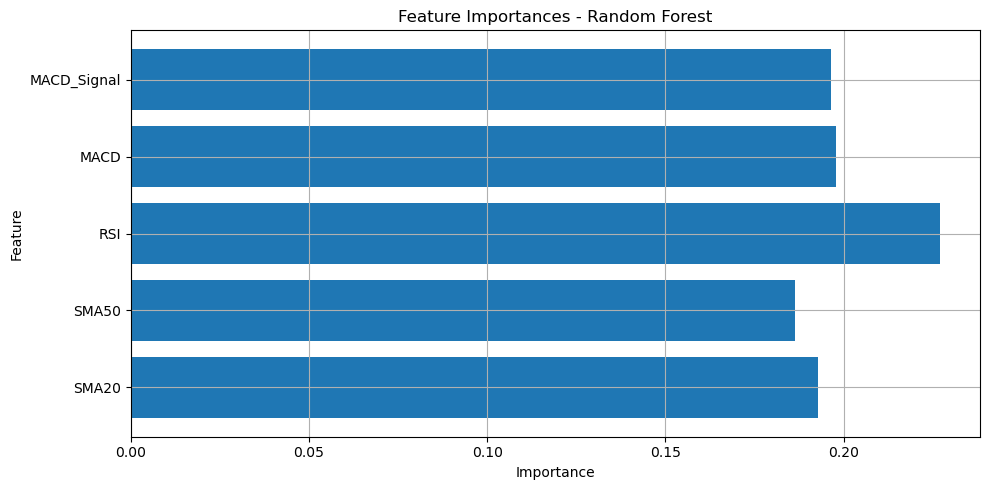

In [55]:
import matplotlib.pyplot as plt

importances = rf_model.feature_importances_
feature_names = X.columns

# Plot
plt.figure(figsize=(10, 5))
plt.barh(feature_names, importances)
plt.title("Feature Importances - Random Forest")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.grid(True)
plt.tight_layout()
plt.show()


In [52]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import accuracy_score
import numpy as np

tscv = TimeSeriesSplit(n_splits=5)
model = RandomForestClassifier(n_estimators=100, random_state=42)

scores = []

for train_idx, val_idx in tscv.split(X):
    X_train_fold, X_val_fold = X.iloc[train_idx], X.iloc[val_idx]
    y_train_fold, y_val_fold = y.iloc[train_idx], y.iloc[val_idx]
    
    model.fit(X_train_fold, y_train_fold.values.ravel())
    preds = model.predict(X_val_fold)
    acc = accuracy_score(y_val_fold, preds)
    scores.append(acc)

print("Cross-Validation Scores:", np.round(scores, 4))
print("Average CV Accuracy:", np.mean(scores).round(4))


Cross-Validation Scores: [0.5124 0.5622 0.5323 0.4925 0.393 ]
Average CV Accuracy: 0.4985


In [56]:
from xgboost import XGBClassifier

xgb = XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=4, random_state=42)
xgb.fit(X_train, y_train)

y_pred_xgb = xgb.predict(X_test)
print("XGBoost Accuracy:", accuracy_score(y_test, y_pred_xgb))
print("Classification Report:\n", classification_report(y_test, y_pred_xgb))


XGBoost Accuracy: 0.45454545454545453
Classification Report:
               precision    recall  f1-score   support

           0       0.42      0.71      0.53       103
           1       0.55      0.27      0.36       139

    accuracy                           0.45       242
   macro avg       0.48      0.49      0.44       242
weighted avg       0.49      0.45      0.43       242



In [60]:

model = LGBMClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)


[LightGBM] [Info] Number of positive: 508, number of negative: 457
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000283 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 965, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.526425 -> initscore=0.105798
[LightGBM] [Info] Start training from score 0.105798


LGBMClassifier(random_state=42)

LightGBM Accuracy: 0.44214876033057854
Classification Report:
               precision    recall  f1-score   support

           0       0.42      0.82      0.55       103
           1       0.55      0.17      0.25       139

    accuracy                           0.44       242
   macro avg       0.48      0.49      0.40       242
weighted avg       0.49      0.44      0.38       242



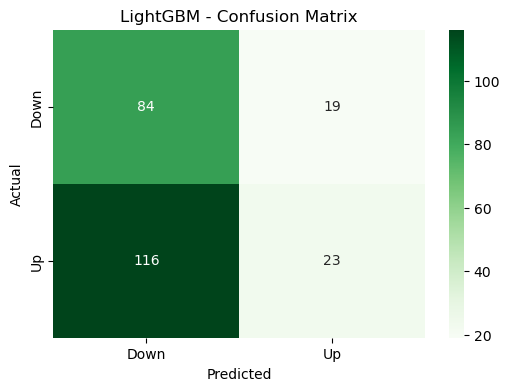

In [ ]:


# Predict
y_pred_lgbm = model.predict(X_test)

# Accuracy
print("LightGBM Accuracy:", accuracy_score(y_test, y_pred_lgbm))

# Classification report
print("Classification Report:\n", classification_report(y_test, y_pred_lgbm))



conf_mat = confusion_matrix(y_test, y_pred_lgbm)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Greens', xticklabels=['Down', 'Up'], yticklabels=['Down', 'Up'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('LightGBM - Confusion Matrix')
plt.show()


In [68]:
y_probs = model.predict_proba(X_test)[:, 1]  # probability of class 'Up'

# Change threshold from 0.5 to something like 0.4
y_pred_custom = (y_probs > 0.5).astype(int)

# Re-evaluate
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test, y_pred_custom))
print(confusion_matrix(y_test, y_pred_custom))


              precision    recall  f1-score   support

           0       0.42      0.82      0.55       103
           1       0.55      0.17      0.25       139

    accuracy                           0.44       242
   macro avg       0.48      0.49      0.40       242
weighted avg       0.49      0.44      0.38       242

[[ 84  19]
 [116  23]]
